<a id='title'></a>
# Moth - Mura
MUNI Omniscient Tutor Helper - Masaryk University Repository Analyzer

This tool was created as a part of the thesis *"Measuring Software Development Contributions using Git"* thesis at Masaryk University.
The goal of this tool is to analyze git repositories of students and provide useful information to tutor about their work.

The implementation is originally written in Python 3.9 and uses the following libraries without which the tool would not be possible:
- [levenshtein](https://pypi.org/project/python-Levenshtein/) - for fuzzy matching in syntactic analysis
- [GitPython](https://gitpython.readthedocs.io/en/stable/) - for git operations
- [python-gitlab](https://python-gitlab.readthedocs.io/en/stable/) - for interfacing with GitLab
- [PyGithub](https://pygithub.readthedocs.io/en/latest/) - for interfacing with GitHub
- [matplotlib](https://matplotlib.org/) - for plotting various graphs
- [notebook](https://jupyter.org/) - for the front-end you are currently using
- [python-sonarqube-api](https://python-sonarqube-api.readthedocs.io/) - for interfacing with SonarQube Community Edition
- [docker](https://www.docker.com/) - for managing docker containers for SonarQube

Below are the necessary imports for the tool to work.

In [1]:
%%time
import fs_access as file_system
import lib
import mura
import configuration
import semantic_analysis

from uni_chars import *  # shortcut for unicode characters used throughout the tool
from history_analyzer import CommitRange

from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # wide screen support

# macros for automagically reloading the modules when they are changed
%load_ext autoreload
%autoreload 2

print(f"{SUCCESS} Imports loaded successfully.")

✅ Imports loaded successfully.
CPU times: total: 46.9 ms
Wall time: 667 ms


<a id='toc'></a>
# Table of contents [↩](#title)
## Setup
- [Configuration](#configuration)
- [Repository setup](#repository)
- [Contributors](#contributors)
- [Config Overrides](#overrides)
- [Analysis](#analysis)
## Results
- [Commits](#commits)
- [Commit Graph](#commit-graph)
- [File statistics](#file-stats)
- [File ownership](#percentage-ownership)
- [File ownership dir-tree](#ownership-dir-tree)
- [Line distribution](#lines)
- [Unmerged commits](#unmerged-commits)
- [Syntax + Semantics](#syntax-semantics)
- [Constructs](#constructs)
- [Hour estimation](#hour-estimation)
- [Remote repository](#remote-repo)
- [Rules](#rules)
- [Summary](#summary)

<a id='configuration'></a>
# Configuration [↩](#toc)

The following code block is a shortcut for opening the configuration folder. The configuration folder contains configuration.txt with general variables and a rules.txt which holds rules to use during ownership analysis.


In [2]:
# configuration.open_configuration_folder()


Apart from the two files mentioned before, separate folders exist for `lang-syntax` and `lang-semantics`. Each definition of a language is stored in a file/folder matching the language's file extension.
The `lang-syntax` folder contains weight definitions for the language's syntax.
The `lang-semantics` folder contains weight definitions for semantics and semantic analyzers themselves as an executable and a launch command for interfacing with the driver python code.
A separate folder `remote-repo-weights` contains weight definitions for remote repository objects: Issues and Pull Requests.

## Configuration file
- `configuration_data/configuration.txt` - contains general configuration of the tool
- `lang-syntax/*` - contains weight definitions for general syntax of a language - This is currently not used as the general idea and configuration approach needs more polish.
- `lang-semantics/*` - contains weight definitions for semantic constructs
- `remote-repo-weigths/weights.txt` - contains weight definitions for remote repository objects

## Rules file

- `configuration_data/rules.txt` - contains rules for the tool

Once the configuration is set, run the code block below to load the configurations into the tool.

In [3]:
%%time
config = configuration.validate()

# All properties of the config can be edited here. An editor with code completion support is recommended.

# Ignore remote repository (GitHub, GitLab). Weights obtained from Issues and Pull Requests won't be available.
# config.ignore_remote_repo = True

# Use SonarQube Community Edition for syntactic/semantic analysis - requires Docker to be installed.
config.use_sonarqube = True
config.sonarqube_persistent = True
config.sonarqube_login = "admin"
config.sonarqube_password = "123456"
config.sonarqube_port = 8080

# Add extensions to the list to ignore during analysis, provide extensions will not be analyzer even if an analyzer is present.
# config.ignored_extensions = ['.cs']

config.post_validate()

📝 Loading general configuration!
✅ General configuration loaded successfully!
📝 GitLab access token found! It will be validated when repository is set!
📝 GitHub access token found! It will be validated when repository is set!
📝 Loading rules!
 - Rule: All contributors must have at least 1 file/s matching: `.*Controller.*\.java` in a directory matching: `*`
 - Rule: All contributors must have at least 1 file/s matching: `.*Test.*\.java` in a directory matching: `*`
 - Rule: All contributors must have at least 1 file/s matching: `pom\.xml` in a directory matching: `*`
 - Rule: All contributors must have at least 1 authored pull request/s.
 - Rule: All contributors must have at least 1 authored issue/s.

✅ Rules loaded successfully!
✅ Configuration loaded successfully!

📝 Semantic analyzers available:
➕ Semantic analyzer for .cs extension
🚀 Launch command in 'target': dotnet CSharpAST.dll
⚠️ Setup file exists! It contains the following information:
Semantic analyzer for .NET projects.

Re

Semantic analyzers for each extension are executed only if the extension is present in the repository. Therefore, it is not required to have all the prerequisites installed if the project does not include those extensions.

<a id='repository'></a>
# Repository [↩](#toc)

Put the path to the repository you want to analyze into the `repository_path` variable and run the code block below.

In [4]:
%%time
repository_path = r"C:\MUNI\last\Java\M1\airport-manager"

repository = file_system.validate_repository(repository_path, config)

✅ Repository path 'C:\MUNI\last\Java\M1\airport-manager' points to a repository
📝 Remote repository found: https://gitlab.fi.muni.cz/xstys/airport-manager (GitLabRepository)
✅ GitLab access token validated successfully!
CPU times: total: 0 ns
Wall time: 321 ms


<a id='commit-range'></a>
# Commit range [↩](#toc)
The commit range is defined by the `start` and `end` variables. The variables can be either a commit hash or a tag/branch name.
Additionally, the `end` variable can be set to `ROOT` and `start` to `HEAD` to analyze the repository from the beginning to the current state.

In [5]:
%%time
start = "HEAD"
end = "ROOT"

commit_range = CommitRange(repository, start, end, verbose=True)

# The expected amount of hours students are expected to spend on the project (for the given commit range), used for hour weight estimation.
hour_estimate_per_contributor = 24

✅ Commit range: 921737c398c70e065c41a2799f6fd998484f1871...bcdfbfd57c8f3cd6cd65998464bb71a562d49948
 - Final commit on: 2023-03-26 23:53:22+02:00
 - Initial commit on: 2019-03-06 09:52:24+01:00
CPU times: total: 0 ns
Wall time: 268 ms


<a id='contributors'></a>
## Contributors [↩](#toc)
Displays a table of all contributors in the repository. The instance contains the following information:
- Name
- Email
- Aliases

Often times contributors do not have a synchronized git configuration across all development devices. This can lead to the tool not being able to properly group contributions to the correct contributor. The tool attempts to match contributors by their name and email. The primary name for a contributor is the chosen as the first encounter (commit) author name.

Aliases are also used to match the contributors. If an alias matches commit author (again by name or email), the primary contributor name is used instead.

In [6]:
%%time
raw_contributors = mura.display_contributor_info(commit_range, config)

👨‍💻 Contributors:

Kryštof-Mikuláš Štys <493159@mail.muni.cz> (['Kryštof-Mikuláš Štys <xstys@fi.muni.cz> ([])'])
Tereza Vrabcová <xvrabcov@ACER-TRAVEL.localdomain> (['Tereza Vrabcová <xvrabcov@fi.muni.cz> ([])'])
Matej Gorgol <56208414+Mateorid@users.noreply.github.com> ([])
Jan Sýkora <485598@muni.cz> (['Jan Sýkora <xsykora4@fi.muni.cz> ([])'])
Tomáš Tomala <tomalatms@gmail.com> (['Tomáš Tomala <xtomala@fi.muni.cz> ([])'])
GitLab <root@localhost> ([])
Matěj Gorgol <xgorgol@fi.muni.cz> ([])
CPU times: total: 0 ns
Wall time: 50.4 ms


### Contributors
If matching by name and email is not enough an explicit name-to-name mapping can be provided in the `contributor_map` variable. Afterwards, executing the block will show the new contributor identifiers.


In [7]:
%%time
contributor_map = \
    [
        # ('Jiří Šťastný', 'Jiri Stastny'),
        ('Matej Gorgol', 'Matěj Gorgol')
    ]

config.contributor_map = contributor_map

contributors = mura.display_contributor_info(commit_range, config)

👨‍💻 Contributors:

Kryštof-Mikuláš Štys <493159@mail.muni.cz> (['Kryštof-Mikuláš Štys <xstys@fi.muni.cz> ([])'])
Tereza Vrabcová <xvrabcov@ACER-TRAVEL.localdomain> (['Tereza Vrabcová <xvrabcov@fi.muni.cz> ([])'])
Matej Gorgol <56208414+Mateorid@users.noreply.github.com> (['Matěj Gorgol <xgorgol@fi.muni.cz> ([])'])
Jan Sýkora <485598@muni.cz> (['Jan Sýkora <xsykora4@fi.muni.cz> ([])'])
Tomáš Tomala <tomalatms@gmail.com> (['Tomáš Tomala <xtomala@fi.muni.cz> ([])'])
GitLab <root@localhost> ([])
CPU times: total: 15.6 ms
Wall time: 52 ms


<a id='overrides'></a>
## Overrides [↩](#toc)
In case a commit was created on behalf of another person, the file ownership is contributed towards the author of the commit. This can lead to incorrect ownership attribution. To fix this, commit ownerships can be overridden by the following code block. The key is the complete commit hash and the value is the contributor name. The contributor name must match the name of a contributor in the `contributors` variable.

📝 This is a last resort solution. Ideally students should commit on their own behalf.


In [8]:
commit_range.ownership_overrides["commit_hexsha"] = "Jiri Stastny"

# Uncomment the following line to enable anonymous mode, which will replace the names of the contributors with "Contributor #n"
# config.anonymous_mode = True

# Uncomment the following line to force skip analysis of a specific extension, e.g. ".cs".
# config.ignored_extensions = [".cs"]


<a id='analysis'></a>
# Analysis [↩](#toc)
The analysis is a time-consuming process. Taking longer the larger the repository is. For a single project from the PA165 course for Milestone 1 (120 commits), the analysis took about 10 seconds on an Intel i7-12700H CPU. If SonarQube is used, the analysis is started in the background. Sonar cube analysis usually takes longer but is more extensive. The results are later retrieved using the project key. The analysis can be skipped by setting `config.use_sonarqube` to `False`.

In [9]:
%%time
project_key = mura.start_sonar_analysis(config, repository_path)

tracked_files = lib.get_tracked_files(repository, verbose=True)
history_analysis_result = commit_range.analyze(verbose=True)

semantic_analysis_grouped_result = semantic_analysis.compute_semantic_weight_result(config, tracked_files, verbose=True)

✅ SonarQube instance is starting...
📝 SonarQube instance is persistent. Data will be stored in 'C:\MUNI\xth. semester\sdipr\src\data\sonarqube_data' and logs in 'C:\MUNI\xth. semester\sdipr\src\data\sonarqube_logs'.
📝 Project 'C:\MUNI\last\Java\M1\airport-manager' already exists. Skipping creation.
📝 Last analysis date: 2023-04-10 20:42:51+02:00

📝 SonarQube 'sonar-scanner-cli' is performing analysis in the background...
✅ Found 91 groups of related files.
📝 Analyzing commit bcdfbfd57c8f3cd6cd65998464bb71a562d49948 (1/141)
📝 Analyzing commit 3bd69e8ac00bd50222abac313a5b47c14a437606 (2/141)
📝 Analyzing commit a1b77e34d5b39941b8a713f3a9e3bf8875e7d52b (3/141)
📝 Analyzing commit 448c12e92d4e52a0c6b3078c16f0f29e601cfbc4 (4/141)
📝 Analyzing commit 21d2e3574f488b91e5e210dc94b24fa434dd1b4c (5/141)
📝 Analyzing commit aca8c18a5a3e728f01d2f9d4e4e18c5f62322f3a (6/141)
📝 Analyzing commit e183ad948e47f0d5306505abf92395b3cbbcb4f1 (7/141)
📝 Analyzing commit 3500a9160488e9c2766fee815b49f3bcc8923efb (8/

# Results

The analysis part is finished. The tool provides multiple outputs to help the tutor analyze the students' work. Each output is a separate function code block. Each section links back to the Table of Contents to make it easier to navigate. Apart from output here in the notebook, SonarQube provides a web interface to view the results of its analysis. The web interface can be accessed at `http://localhost:{port}` if SonarQube is enabled in the configuration at the specified port.

<a id='commits'></a>
## Commits [↩](#toc)

The following code block displays a table of all commits in the repository. For each commit, the full commit hash, the first line of the commit message and the author are displayed.

The commits are then grouped by contributors and additional information about total inserted and deleted lines over the commits are displayed in textual and graphical form.

In [10]:
%%time
commit_distribution, insertions_deletions = mura.commit_info(commit_range, repository, contributors)

⬆️ Total commits: 141

Commit: bcdfbfd57c8f3cd6cd65998464bb71a562d49948 - Msg: "Initial template creation" by 👨‍💻 GitLab
Commit: 3bd69e8ac00bd50222abac313a5b47c14a437606 - Msg: "[Feat] Working project" by 👨‍💻 Kryštof-Mikuláš Štys
Commit: a1b77e34d5b39941b8a713f3a9e3bf8875e7d52b - Msg: "[Feat] Steward-module initialization" by 👨‍💻 Kryštof-Mikuláš Štys
Commit: 448c12e92d4e52a0c6b3078c16f0f29e601cfbc4 - Msg: "[Feat] DomainEntity" by 👨‍💻 Kryštof-Mikuláš Štys
Commit: 21d2e3574f488b91e5e210dc94b24fa434dd1b4c - Msg: "[Feat] Initial steward object without validity check" by 👨‍💻 Kryštof-Mikuláš Štys
Commit: aca8c18a5a3e728f01d2f9d4e4e18c5f62322f3a - Msg: "[Feat] DomainModule for generic classes" by 👨‍💻 Kryštof-Mikuláš Štys
Commit: e183ad948e47f0d5306505abf92395b3cbbcb4f1 - Msg: "[Feat] Steward add + tests + update" by 👨‍💻 Kryštof-Mikuláš Štys
Commit: 3500a9160488e9c2766fee815b49f3bcc8923efb - Msg: "[Feat] Update Steward" by 👨‍💻 Kryštof-Mikuláš Štys
Commit: 770643095e335002c031ec340f1fb8d3f85ef1

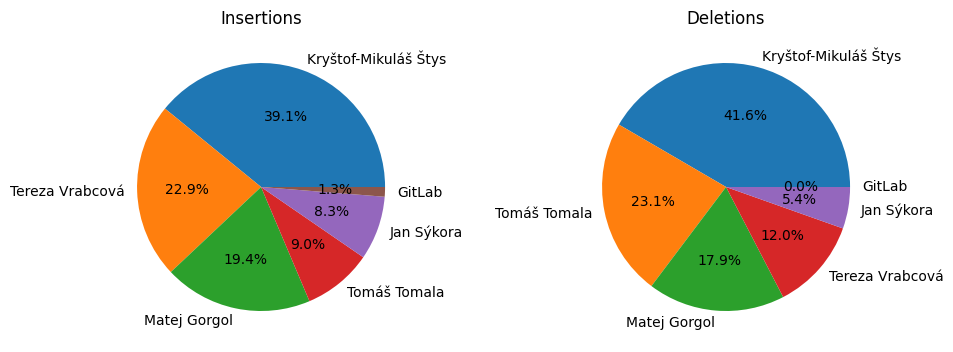

CPU times: total: 93.8 ms
Wall time: 135 ms


In [11]:
%%time
mura.insertions_deletions_info(insertions_deletions)

<a id='commit-graph'></a>
## Commit graph [↩](#toc)
Displays a graph of the commits in the repository.

The x axis is the time axis. The y axis is the number of commits. Each dot in the graph represents a commit. The color of the dot represents the author of the commit.

The range of the x-axis is computed from the starting commit date and the ending commit date.
To display only a section of the graph, the list can be sliced. This is generally useful to filter out commits at the boundaries. Taking a section in the middle does not make much sense.

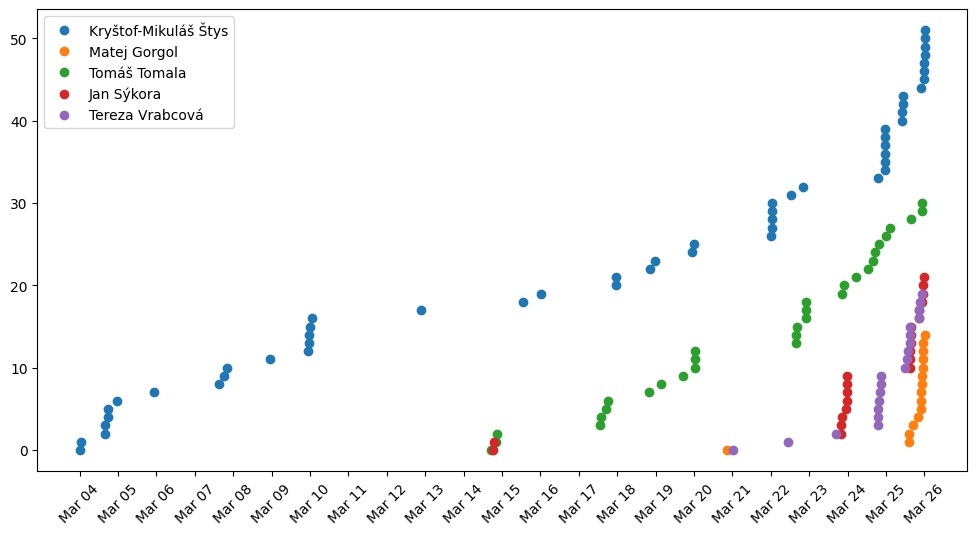

CPU times: total: 109 ms
Wall time: 376 ms


In [12]:
%%time
commits = [commit for commit in commit_range]

commits = commits[1:]  # remove first commit
# commits = commits[:10] # remove last 10 commits

mura.plot_commits(commits, commit_range, contributors, repository, force_x_axis_dense_labels=False)

<a id='file-stats'></a>
## File statistics [↩](#toc)
First part of the output is a combined statistics of all file changes in the repository.

- A: Files Added
- D: Files Deleted
- M: Files Modified
- R: Files Renamed

The statistics are cumulative. Meaning if a file is added and in any subsequent commit it is deleted, the file is counted towards both statistics.

In [13]:
%%time
flagged_files = mura.file_statistics_info(commit_range, contributors)

👨‍💻 Kryštof-Mikuláš Štys <493159@mail.muni.cz> (['Kryštof-Mikuláš Štys <xstys@fi.muni.cz> ([])']))
 => A - 238
 => R - 8
 => D - 21
 => M - 184
👨‍💻 Tereza Vrabcová <xvrabcov@ACER-TRAVEL.localdomain> (['Tereza Vrabcová <xvrabcov@fi.muni.cz> ([])']))
 => A - 111
 => R - 1
 => D - 0
 => M - 64
👨‍💻 Matej Gorgol <56208414+Mateorid@users.noreply.github.com> (['Matěj Gorgol <xgorgol@fi.muni.cz> ([])']))
 => A - 121
 => R - 2
 => D - 10
 => M - 42
👨‍💻 Jan Sýkora <485598@muni.cz> (['Jan Sýkora <xsykora4@fi.muni.cz> ([])']))
 => A - 58
 => R - 22
 => D - 4
 => M - 31
👨‍💻 Tomáš Tomala <tomalatms@gmail.com> (['Tomáš Tomala <xtomala@fi.muni.cz> ([])']))
 => A - 47
 => R - 21
 => D - 4
 => M - 86
👨‍💻 GitLab <root@localhost> ([]))
 => A - 6
 => R - 0
 => D - 0
 => M - 0
CPU times: total: 46.9 ms
Wall time: 6.46 s


<a id='percentage-ownership'></a>
## Percentages and ownership [↩](#toc)

The following code block displays the percentage of ownership of each contributor. The percentage is computed based on the number of lines of code contributed by the contributor. The percentage is computed for each file and then summed up for each contributor.

The first output shows the total share of code across the project.
Then the individual files are listed.

In [14]:
%%time
percentage, ownership = mura.percentage_info(history_analysis_result, contributors, config)

📊 Percentage of tracked files:

	Kryštof-Mikuláš Štys <493159@mail.muni.cz> (['Kryštof-Mikuláš Štys <xstys@fi.muni.cz> ([])']): 24.15%
	GitLab <root@localhost> ([]): 3.20%
	Tomáš Tomala <tomalatms@gmail.com> (['Tomáš Tomala <xtomala@fi.muni.cz> ([])']): 21.76%
	Tereza Vrabcová <xvrabcov@ACER-TRAVEL.localdomain> (['Tereza Vrabcová <xvrabcov@fi.muni.cz> ([])']): 25.69%
	Matej Gorgol <56208414+Mateorid@users.noreply.github.com> (['Matěj Gorgol <xgorgol@fi.muni.cz> ([])']): 15.25%
	Jan Sýkora <485598@muni.cz> (['Jan Sýkora <xsykora4@fi.muni.cz> ([])']): 9.95%
Files owned by 👨‍💻 Kryštof-Mikuláš Štys
	C:\MUNI\last\Java\M1\airport-manager\.mvn\wrapper\maven-wrapper.properties (1)
	C:\MUNI\last\Java\M1\airport-manager\steward-module\.mvn\wrapper\maven-wrapper.properties (1)
	C:\MUNI\last\Java\M1\airport-manager\steward-module\mvnw (1)
	C:\MUNI\last\Java\M1\airport-manager\steward-module\mvnw.cmd (1)
	C:\MUNI\last\Java\M1\airport-manager\steward-module\pom.xml (1)
	C:\MUNI\last\Java\M1\airport-

<a id='ownership-dir-tree'></a>
## Ownership as a directory tree [↩](#toc)

The above output is not very readable, to offer a nicer view and also show ownership of directories based on their contents, the following code block displays the ownership as a directory tree.

In [15]:
%%time
mura.display_dir_tree(config, percentage, repository)

📁 Dir Tree with ownership:

├── .gitignore 👨‍💻 [Kryštof-Mikuláš Štys: 27%, GitLab: 73%]
├── .mvn
│   └── wrapper
│       └── maven-wrapper.properties 👨‍💻 [Kryštof-Mikuláš Štys: 94%, GitLab: 6%]
├── README.md 👨‍💻 [Tomáš Tomala: 100%]
├── mvnw 👨‍💻 [GitLab: 69%, Kryštof-Mikuláš Štys: 31%]
├── mvnw.cmd 👨‍💻 [GitLab: 69%, Kryštof-Mikuláš Štys: 31%]
├── pom.xml 👨‍💻 [Tereza Vrabcová: 75%, Matej Gorgol: 25%]
├── steward-module 👨‍💻 [Kryštof-Mikuláš Štys: 94%, Tomáš Tomala: 6%]
│   ├── .mvn
│   │   └── wrapper
│   │       └── maven-wrapper.properties 👨‍💻 [Kryštof-Mikuláš Štys: 100%]
│   ├── mvnw 👨‍💻 [Kryštof-Mikuláš Štys: 100%]
│   ├── mvnw.cmd 👨‍💻 [Kryštof-Mikuláš Štys: 100%]
│   ├── pom.xml 👨‍💻 [Kryštof-Mikuláš Štys: 91%, Tomáš Tomala: 9%]
│   └── src 👨‍💻 [Kryštof-Mikuláš Štys: 77%, Tomáš Tomala: 23%]
│       ├── main
│       │   └── java
│       │       └── cz
│       │           └── muni
│       │               └── fi
│       │                   └── pa165
│       │                       └── a

<a id='lines'></a>
## Lines, Blanks and Comments [↩](#toc)

In this section, apart from number of lines, top 5 largest and smallest files are shown, this number exposed as `n_extreme_files`. Setting the value to 0 skips the section about largest/smallest files. The information about comments is taken from the final state of the project.

In [16]:
%%time
mura.lines_blanks_comments_info(repository, ownership, semantic_analysis_grouped_result, tracked_files, n_extreme_files=5)

⬛️ Blanks and comments:

📝 Total lines: 6857 across 170 files.
📝 Largest files:
 => flight-module\src\test\java\service\FlightServiceAddTest.java (341) by 👨‍💻: Tereza Vrabcová
 => steward-module\src\test\java\service\StewardServiceUpdateTest.java (219) by 👨‍💻: Tomáš Tomala
 => flight-module\src\test\java\facade\FlightFacadeTest.java (210) by 👨‍💻: Tereza Vrabcová
 => steward-module\src\test\java\repository\StewardRepositoryUpdateTest.java (183) by 👨‍💻: Kryštof-Mikuláš Štys
 => plane-module\src\test\java\cz\muni\fi\pa165\airportmanager\planemodule\service\PlaneServiceUpdateTest.java (180) by 👨‍💻: Tomáš Tomala
📝 Smallest files:
 => domain-module\src\main\java\cz\muni\fi\pa165\airportmanager\domainmodule\dto\DomainInsertDto.java (8) by 👨‍💻: Kryštof-Mikuláš Štys
 => domain-module\src\main\java\cz\muni\fi\pa165\airportmanager\domainmodule\exception\InvalidUserInputException.java (11) by 👨‍💻: Tomáš Tomala
 => domain-module\src\main\java\cz\muni\fi\pa165\airportmanager\domainmodule\datetimepro

<a id='unmerged-commits'></a>
## Unmerged commits [↩](#toc)

This section analyzes branches that exist in the repository between the `start` and `end` commit but were not merged into the main branch.

In [17]:
%%time
commit_range.unmerged_commits_info(repository, config, contributors)

⚠️ Unmerged branch: origin/flight-mock
48eb8f82ac776fb617af5c90c760f43767720f58 ➡️ ⬆️ Commit: removed newline (Tereza Vrabcová)
                   ⬇️                   
4b46e8132d4f65a1c4d155b7941ba2375ece7d90 ➡️ ⬆️ Commit: Merge branch 'develop' into flight-mock (Tereza Vrabcová)
                   ⬇️                   
07c6f9dd75d5cd6e003fe1f3776b47e4351a2fb2 ➡️ ⬆️ Commit: Merge branch 'exception-when-updating-nonexistant-entity' into 'develop' (Kryštof-Mikuláš Štys)
CPU times: total: 0 ns
Wall time: 133 ms


<a id='syntax-semantics'></a>
## Syntax using SonarQube + Semantics [↩](#toc)

Apart from inspection performed by the tool itself, outputs from SonarQube are also available. The analysis is done in a Docker container in the steps above. The code block below will wait until the analysis is done and then query SonarQube for the results. The web interface can be accessed as well to view further results not used by Mura.

The semantic info call uses the built-in analyzers to obtain information about code constructs for each analyzed file. The results are grouped by folders.

In [18]:
%%time
syntactic_weights = mura.syntax_info(config, contributors, repository, ownership, project_key)

📖 Syntax + Semantics using SonarQube:

📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
📝 Analysis is running. Waiting for it to finish...
✅ SonarQube analysis finished.

🔥 Reported Issues:

⚠️ Severity: MAJOR --> 'Remove this expression which always evaluates to "true"
 -> In file: destination-module\src\main\java\cz\muni\fi\pa165\airportmanager\moduledestination\data\repository\Des

In [19]:
%%time
semantic_weights = mura.semantic_info(tracked_files, ownership, semantic_analysis_grouped_result)

📚 Semantics:

📦 Group: C:\MUNI\last\Java\M1\airport-manager
Total files: 6
🏆 Total weight: 0.0

📦 Group: C:\MUNI\last\Java\M1\airport-manager\.mvn\wrapper
Total files: 1
🏆 Total weight: 0.0

📦 Group: C:\MUNI\last\Java\M1\airport-manager\.scannerwork
Total files: 2
🏆 Total weight: 0.0

📦 Group: C:\MUNI\last\Java\M1\airport-manager\airlines-module
Total files: 4
🏆 Total weight: 0.0

📦 Group: C:\MUNI\last\Java\M1\airport-manager\airlines-module\.mvn\wrapper
Total files: 1
🏆 Total weight: 0.0

📦 Group: C:\MUNI\last\Java\M1\airport-manager\airlines-module\src\main\java\cz\muni\fi\pa165\airportmanager\airlinesmodule
Total files: 1
File: AirlinesModuleApplication.java: Owner: Matej Gorgol
Contents: Classes: 1 Functions: 1 Properties: 0 Fields: 0 Comments: 0 
🏆 Semantic file weight: 58.0
🏆 Total weight: 58.0

📦 Group: C:\MUNI\last\Java\M1\airport-manager\airlines-module\src\main\java\cz\muni\fi\pa165\airportmanager\airlinesmodule\data\model
Total files: 1
File: Airline.java: Owner: Matej Gorgo

<a id='constructs'></a>
## Constructs and ownership [↩](#toc)

The following code block summarizes the data obtained in the previous step into a more readable format. Discarding details and presenting counts of constructs owned by a contributor.

In [20]:
%%time
mura.constructs_info(tracked_files, ownership, semantic_analysis_grouped_result)

📚 Constructs:

👨‍💻 Matej Gorgol
  Owns:
   => class - 15
   => function - 75
   => field - 26
   => comment - 40
👨‍💻 Jan Sýkora
  Owns:
   => class - 12
   => function - 38
   => field - 9
   => comment - 9
👨‍💻 Kryštof-Mikuláš Štys
  Owns:
   => class - 24
   => field - 38
   => function - 141
   => comment - 51
👨‍💻 Tomáš Tomala
  Owns:
   => class - 23
   => comment - 41
   => function - 133
   => field - 17
👨‍💻 Tereza Vrabcová
  Owns:
   => class - 18
   => function - 114
   => field - 26
   => comment - 19
CPU times: total: 0 ns
Wall time: 5.94 ms


<a id='hour-estimation'></a>
## Hour estimation [↩](#toc)

Hour estimation in based on the tool git-hours available [here](https://github.com/kimmobrunfeldt/git-hours). The angorithm was wertitten into python to remove the need to install npm and all complete all the necessary steps. The estimated hours are then used to compute weights for each contributor based on normal distribution.

In [21]:
%%time
hour_estimates = mura.hour_estimates(contributors, repository)

hour_weights = mura.gaussian_weights(config, hour_estimate_per_contributor, hour_estimates)

⏱ Hour estimates:

👨‍💻 Kryštof-Mikuláš Štys has:
 => 52 commits
 => ⏱ ~54 hours of work
👨‍💻 Tereza Vrabcová has:
 => 20 commits
 => ⏱ ~17 hours of work
👨‍💻 Matej Gorgol has:
 => 15 commits
 => ⏱ ~10 hours of work
👨‍💻 Jan Sýkora has:
 => 22 commits
 => ⏱ ~13 hours of work
👨‍💻 Tomáš Tomala has:
 => 31 commits
 => ⏱ ~41 hours of work
👨‍💻 GitLab has:
 => 1 commits
 => ⏱ ~0 hours of work

🏆 Gaussian weights:

👨‍💻 Kryštof-Mikuláš Štys:
 => 24.90 🏆 Weight gained for: 54 hours of work.
👨‍💻 Tereza Vrabcová:
 => 139.49 🏆 Weight gained for: 17 hours of work.
👨‍💻 Matej Gorgol:
 => 17.26 🏆 Weight gained for: 10 hours of work.
👨‍💻 Jan Sýkora:
 => 62.48 🏆 Weight gained for: 13 hours of work.
👨‍💻 Tomáš Tomala:
 => 82.87 🏆 Weight gained for: 41 hours of work.
👨‍💻 GitLab:
 => 📝 Estimated 0 hours.
CPU times: total: 0 ns
Wall time: 61.4 ms


<a id='remote-repo'></a>
## Remote repository [↩](#toc)

Apart from code, Mura also analyzes the remote repository is instructed to do so. The following code block displays the number of issues and pull requests. Each "remote object" in participating in the weight computation. Complex pull requests and stale pull requests are penalized. Merging pull requests as self without code review is also penalized.

In [33]:
%%time
remote_project, repo_management_weights = mura.remote_info(commit_range, repository, config, contributors)

🌐 Remote repository management:

Project: Airport Manager
📋 Total issues: 10
🔄 Total pull requests: 16
👨‍💻 Total contributors: 6
📝 All of the presented information were extracted from https://gitlab.fi.muni.cz/xstys/airport-manager.
📝 Checking for issues and pull requests between 2019-03-06 09:52:24+01:00 and 2023-03-26 23:59:59.999999+02:00.

📋 Issue: Artifacts creation only for develop - by Kryštof-Mikuláš Štys

Description: - [x] Check if the artefact issue really is due to the number of artefacts or just due to the size of our artefact.
- [x] Find a good solution for artefacts only in master/ develop.
Closed at: 2023-04-06 10:55:10.649000+02:00 by Matej Gorgol
📝 Issue was not closed during the period or did not exist at all.
🏆 Weight 0.0 - Beneficiaries: Matej Gorgol, Kryštof-Mikuláš Štys

📋 Issue: make repo update & delete throw exception - by Matej Gorgol

Description: updateEntity & deleteEntity in DomainRepository should throw exception when trying to update/delete nonexisting/

<a id='rules'></a>
## Rules [↩](#toc)

Rules are an easy way to assert file ownership. Rules are defined in the configuration file mentioned above.

In [34]:
%%time
rule_violation_weight_multipliers = mura.rule_info(config, repository, ownership, contributors, remote_project)

📜 Rules: 

All contributors must have file/s matching: `.*Controller.*\.java` in a directory matching: `*`
All contributors must have file/s matching: `.*Test.*\.java` in a directory matching: `*`
All contributors must have file/s matching: `pom\.xml` in a directory matching: `*`
All contributors must have authored pull request/s.
All contributors must have authored issue/s.

🏆 Weight Multipliers:
	File weight 0.9
	Issue weight 0.98
	Pull request weight 0.9

🚫 Violated Rules: 

❌ Contributor GitLab <root@localhost> ([]) did not fulfill the following requirements:
	All contributors must have authored pull request/s.
	All contributors must have authored issue/s.
❌ Contributor Tereza Vrabcová <xvrabcov@ACER-TRAVEL.localdomain> (['Tereza Vrabcová <xvrabcov@fi.muni.cz> ([])']) did not fulfill the following requirements:
	All contributors must have authored issue/s.
❌ Contributor Jan Sýkora <485598@muni.cz> (['Jan Sýkora <xsykora4@fi.muni.cz> ([])']) did not fulfill the following requirement

<a id='summary'></a>
## Summary [↩](#toc)

Summarizes the data collected in the steps above and displays the final weights for each contributor. Higher weights mean the contributor was more active during the development process. When comparing complexity of two projects the absolute weight can be used to measure complexity between the two projects. Within the project the relative distribution between the contributors can be used to identify stronger and weaker members of the team.

In [35]:
%%time
mura.summary_info(contributors, syntactic_weights, semantic_weights, repo_management_weights,
                  rule_violation_weight_multipliers, hour_weights)



🏆 Total weight per contributor for 📖 SonarQube analysis:
 -> Kryštof-Mikuláš Štys: -421.0
 -> Tereza Vrabcová: -50.0
 -> Matej Gorgol: -39.0
 -> Jan Sýkora: -45.0
 -> Tomáš Tomala: -285.0
 -> GitLab: -24.0


🏆 Total weight per contributor for 📚 Semantics:
 -> Kryštof-Mikuláš Štys: 2020.0
 -> Tereza Vrabcová: 1423.0
 -> Matej Gorgol: 1168.25
 -> Jan Sýkora: 921.25
 -> Tomáš Tomala: 1732.0


🏆 Total weight per contributor for 🌐 Remote repository management:
 -> Kryštof-Mikuláš Štys: 418.0
 -> Tereza Vrabcová: 40.0
 -> Matej Gorgol: 208.0
 -> Jan Sýkora: 60.0
 -> Tomáš Tomala: 120.0


🏆 Total weight per contributor for ⏱ Estimated hours:
 -> Kryštof-Mikuláš Štys: 24.90289428882459
 -> Tereza Vrabcová: 139.49423146499035
 -> Matej Gorgol: 17.2587172998741
 -> Jan Sýkora: 62.48058247595571
 -> Tomáš Tomala: 82.86558237701122


🏆⚠️ Weight multiplier for unfulfilled 📜 Rules:
 -> Tereza Vrabcová: 0.98
 -> Jan Sýkora: 0.98
 -> Tomáš Tomala: 0.98
 -> GitLab: 0.882


🏆 Total weight per contribu